In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
# import plotly.io as pio
# pio.renderers.default = 'notebook'  # 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import plotly.express as px

In [2]:
data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

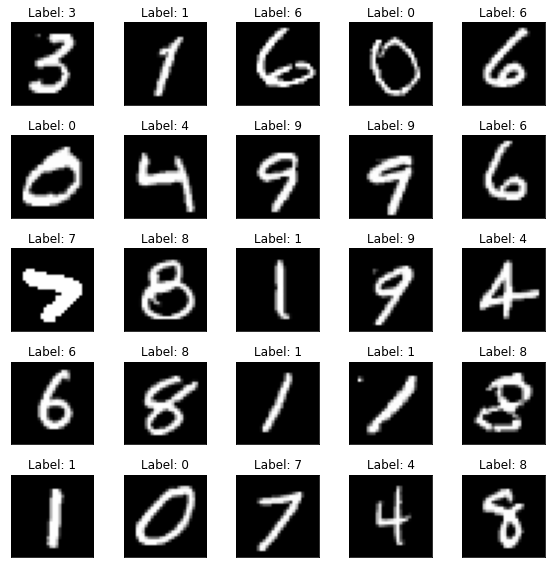

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [9]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.253366
	 partial train loss (single batch): 0.246283
	 partial train loss (single batch): 0.240788
	 partial train loss (single batch): 0.235920
	 partial train loss (single batch): 0.232218
	 partial train loss (single batch): 0.228010
	 partial train loss (single batch): 0.225460
	 partial train loss (single batch): 0.221840
	 partial train loss (single batch): 0.220464
	 partial train loss (single batch): 0.217789
	 partial train loss (single batch): 0.215882
	 partial train loss (single batch): 0.213678
	 partial train loss (single batch): 0.211845
	 partial train loss (single batch): 0.209258
	 partial train loss (single batch): 0.207328
	 partial train loss (single batch): 0.205426
	 partial train loss (single batch): 0.203563
	 partial train loss (single batch): 0.201451
	 partial train loss (single batch): 0.199425
	 partial train loss (single batch): 0.197854
	 partial train loss (single batch): 0.195613
	 partial train loss (single batch

	 partial train loss (single batch): 0.067893
	 partial train loss (single batch): 0.068224
	 partial train loss (single batch): 0.067657
	 partial train loss (single batch): 0.067087
	 partial train loss (single batch): 0.066486
	 partial train loss (single batch): 0.066722
	 partial train loss (single batch): 0.065762
	 partial train loss (single batch): 0.064343

 EPOCH 1/30 	 train loss 0.123 	 val loss 0.065


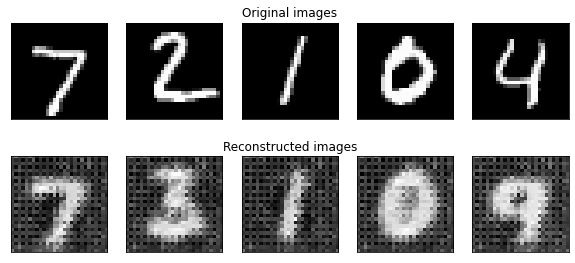

	 partial train loss (single batch): 0.065409
	 partial train loss (single batch): 0.064291
	 partial train loss (single batch): 0.065293
	 partial train loss (single batch): 0.064753
	 partial train loss (single batch): 0.063677
	 partial train loss (single batch): 0.064042
	 partial train loss (single batch): 0.064661
	 partial train loss (single batch): 0.065106
	 partial train loss (single batch): 0.062663
	 partial train loss (single batch): 0.064508
	 partial train loss (single batch): 0.062784
	 partial train loss (single batch): 0.063412
	 partial train loss (single batch): 0.062489
	 partial train loss (single batch): 0.063245
	 partial train loss (single batch): 0.062121
	 partial train loss (single batch): 0.063274
	 partial train loss (single batch): 0.061270
	 partial train loss (single batch): 0.062638
	 partial train loss (single batch): 0.061221
	 partial train loss (single batch): 0.061833
	 partial train loss (single batch): 0.061659
	 partial train loss (single batch

	 partial train loss (single batch): 0.047608
	 partial train loss (single batch): 0.048079
	 partial train loss (single batch): 0.047878
	 partial train loss (single batch): 0.047744
	 partial train loss (single batch): 0.047453
	 partial train loss (single batch): 0.048092
	 partial train loss (single batch): 0.046702
	 partial train loss (single batch): 0.045147

 EPOCH 2/30 	 train loss 0.054 	 val loss 0.047


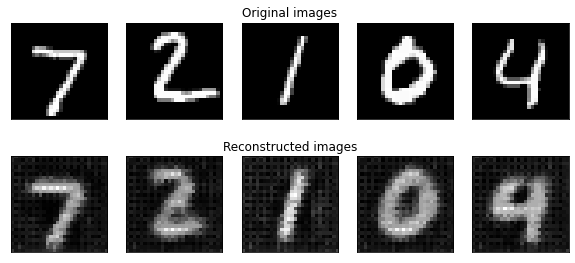

	 partial train loss (single batch): 0.046712
	 partial train loss (single batch): 0.045975
	 partial train loss (single batch): 0.047523
	 partial train loss (single batch): 0.046483
	 partial train loss (single batch): 0.045572
	 partial train loss (single batch): 0.046248
	 partial train loss (single batch): 0.047313
	 partial train loss (single batch): 0.047525
	 partial train loss (single batch): 0.045205
	 partial train loss (single batch): 0.047900
	 partial train loss (single batch): 0.045887
	 partial train loss (single batch): 0.046629
	 partial train loss (single batch): 0.045730
	 partial train loss (single batch): 0.046295
	 partial train loss (single batch): 0.045815
	 partial train loss (single batch): 0.047122
	 partial train loss (single batch): 0.044694
	 partial train loss (single batch): 0.047103
	 partial train loss (single batch): 0.045304
	 partial train loss (single batch): 0.045958
	 partial train loss (single batch): 0.045604
	 partial train loss (single batch

	 partial train loss (single batch): 0.038052
	 partial train loss (single batch): 0.038439
	 partial train loss (single batch): 0.038856
	 partial train loss (single batch): 0.038582
	 partial train loss (single batch): 0.038442
	 partial train loss (single batch): 0.038867
	 partial train loss (single batch): 0.036624
	 partial train loss (single batch): 0.036128

 EPOCH 3/30 	 train loss 0.042 	 val loss 0.038


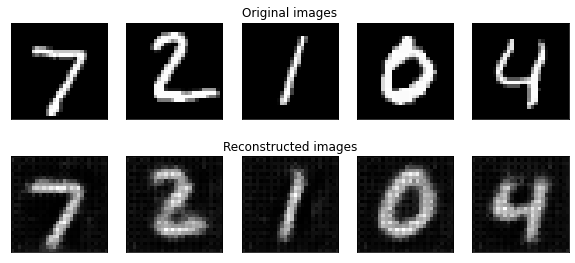

	 partial train loss (single batch): 0.037826
	 partial train loss (single batch): 0.037450
	 partial train loss (single batch): 0.038797
	 partial train loss (single batch): 0.037221
	 partial train loss (single batch): 0.036006
	 partial train loss (single batch): 0.038089
	 partial train loss (single batch): 0.038133
	 partial train loss (single batch): 0.038517
	 partial train loss (single batch): 0.036710
	 partial train loss (single batch): 0.039273
	 partial train loss (single batch): 0.037139
	 partial train loss (single batch): 0.037608
	 partial train loss (single batch): 0.036667
	 partial train loss (single batch): 0.037301
	 partial train loss (single batch): 0.037379
	 partial train loss (single batch): 0.038644
	 partial train loss (single batch): 0.036131
	 partial train loss (single batch): 0.038277
	 partial train loss (single batch): 0.037211
	 partial train loss (single batch): 0.037302
	 partial train loss (single batch): 0.036739
	 partial train loss (single batch

	 partial train loss (single batch): 0.034165
	 partial train loss (single batch): 0.033392
	 partial train loss (single batch): 0.033701
	 partial train loss (single batch): 0.034755
	 partial train loss (single batch): 0.034408
	 partial train loss (single batch): 0.034192
	 partial train loss (single batch): 0.034261
	 partial train loss (single batch): 0.032084
	 partial train loss (single batch): 0.031808

 EPOCH 4/30 	 train loss 0.035 	 val loss 0.034


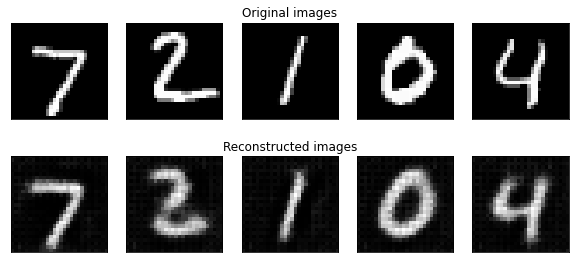

	 partial train loss (single batch): 0.033299
	 partial train loss (single batch): 0.033550
	 partial train loss (single batch): 0.034276
	 partial train loss (single batch): 0.033219
	 partial train loss (single batch): 0.031734
	 partial train loss (single batch): 0.034064
	 partial train loss (single batch): 0.033648
	 partial train loss (single batch): 0.034512
	 partial train loss (single batch): 0.032807
	 partial train loss (single batch): 0.035022
	 partial train loss (single batch): 0.033210
	 partial train loss (single batch): 0.033368
	 partial train loss (single batch): 0.032879
	 partial train loss (single batch): 0.033181
	 partial train loss (single batch): 0.033456
	 partial train loss (single batch): 0.034511
	 partial train loss (single batch): 0.031921
	 partial train loss (single batch): 0.034355
	 partial train loss (single batch): 0.033149
	 partial train loss (single batch): 0.033029
	 partial train loss (single batch): 0.032800
	 partial train loss (single batch

	 partial train loss (single batch): 0.032221
	 partial train loss (single batch): 0.031297
	 partial train loss (single batch): 0.031589
	 partial train loss (single batch): 0.032863
	 partial train loss (single batch): 0.032404
	 partial train loss (single batch): 0.032231
	 partial train loss (single batch): 0.032299
	 partial train loss (single batch): 0.029998
	 partial train loss (single batch): 0.029923

 EPOCH 5/30 	 train loss 0.032 	 val loss 0.032


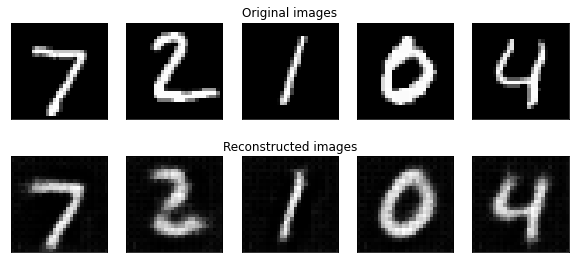

	 partial train loss (single batch): 0.031385
	 partial train loss (single batch): 0.031865
	 partial train loss (single batch): 0.032588
	 partial train loss (single batch): 0.031414
	 partial train loss (single batch): 0.029980
	 partial train loss (single batch): 0.032435
	 partial train loss (single batch): 0.031668
	 partial train loss (single batch): 0.032692
	 partial train loss (single batch): 0.030981
	 partial train loss (single batch): 0.033015
	 partial train loss (single batch): 0.031584
	 partial train loss (single batch): 0.031406
	 partial train loss (single batch): 0.031092
	 partial train loss (single batch): 0.031536
	 partial train loss (single batch): 0.031746
	 partial train loss (single batch): 0.032662
	 partial train loss (single batch): 0.030195
	 partial train loss (single batch): 0.032522
	 partial train loss (single batch): 0.031199
	 partial train loss (single batch): 0.031182
	 partial train loss (single batch): 0.031185
	 partial train loss (single batch

	 partial train loss (single batch): 0.031259
	 partial train loss (single batch): 0.030060
	 partial train loss (single batch): 0.030397
	 partial train loss (single batch): 0.031715
	 partial train loss (single batch): 0.031251
	 partial train loss (single batch): 0.031057
	 partial train loss (single batch): 0.031266
	 partial train loss (single batch): 0.028912
	 partial train loss (single batch): 0.028902

 EPOCH 6/30 	 train loss 0.031 	 val loss 0.031


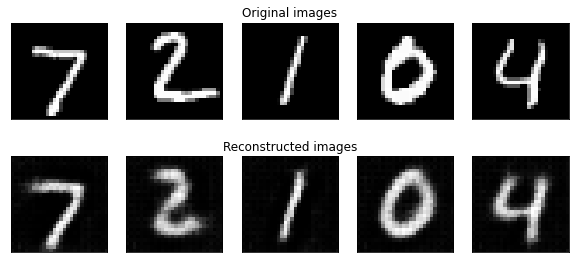

	 partial train loss (single batch): 0.030322
	 partial train loss (single batch): 0.030942
	 partial train loss (single batch): 0.031680
	 partial train loss (single batch): 0.030450
	 partial train loss (single batch): 0.028942
	 partial train loss (single batch): 0.031421
	 partial train loss (single batch): 0.030666
	 partial train loss (single batch): 0.031457
	 partial train loss (single batch): 0.029833
	 partial train loss (single batch): 0.031927
	 partial train loss (single batch): 0.030646
	 partial train loss (single batch): 0.030341
	 partial train loss (single batch): 0.030071
	 partial train loss (single batch): 0.030429
	 partial train loss (single batch): 0.030704
	 partial train loss (single batch): 0.031562
	 partial train loss (single batch): 0.029102
	 partial train loss (single batch): 0.031601
	 partial train loss (single batch): 0.030116
	 partial train loss (single batch): 0.030061
	 partial train loss (single batch): 0.030305
	 partial train loss (single batch

	 partial train loss (single batch): 0.029381
	 partial train loss (single batch): 0.029633
	 partial train loss (single batch): 0.031060
	 partial train loss (single batch): 0.030480
	 partial train loss (single batch): 0.030306
	 partial train loss (single batch): 0.030554
	 partial train loss (single batch): 0.028277
	 partial train loss (single batch): 0.028083

 EPOCH 7/30 	 train loss 0.030 	 val loss 0.030


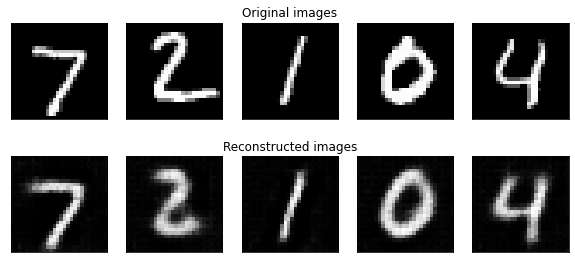

	 partial train loss (single batch): 0.029653
	 partial train loss (single batch): 0.030245
	 partial train loss (single batch): 0.030897
	 partial train loss (single batch): 0.029812
	 partial train loss (single batch): 0.028239
	 partial train loss (single batch): 0.030692
	 partial train loss (single batch): 0.029784
	 partial train loss (single batch): 0.030759
	 partial train loss (single batch): 0.029005
	 partial train loss (single batch): 0.031212
	 partial train loss (single batch): 0.030047
	 partial train loss (single batch): 0.029555
	 partial train loss (single batch): 0.029318
	 partial train loss (single batch): 0.029789
	 partial train loss (single batch): 0.030024
	 partial train loss (single batch): 0.030892
	 partial train loss (single batch): 0.028523
	 partial train loss (single batch): 0.030748
	 partial train loss (single batch): 0.029273
	 partial train loss (single batch): 0.029466
	 partial train loss (single batch): 0.029560
	 partial train loss (single batch

	 partial train loss (single batch): 0.030693
	 partial train loss (single batch): 0.029843
	 partial train loss (single batch): 0.029674
	 partial train loss (single batch): 0.029966
	 partial train loss (single batch): 0.027894
	 partial train loss (single batch): 0.027595

 EPOCH 8/30 	 train loss 0.029 	 val loss 0.030


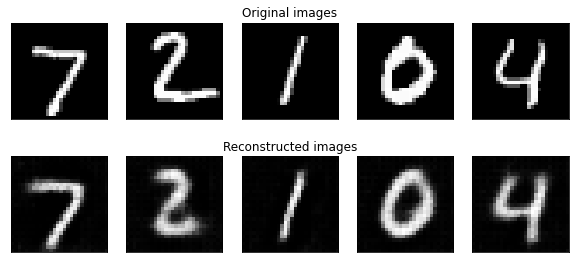

	 partial train loss (single batch): 0.029064
	 partial train loss (single batch): 0.029783
	 partial train loss (single batch): 0.030319
	 partial train loss (single batch): 0.029353
	 partial train loss (single batch): 0.027814
	 partial train loss (single batch): 0.030200
	 partial train loss (single batch): 0.029126
	 partial train loss (single batch): 0.030338
	 partial train loss (single batch): 0.028577
	 partial train loss (single batch): 0.030577
	 partial train loss (single batch): 0.029460
	 partial train loss (single batch): 0.029220
	 partial train loss (single batch): 0.028649
	 partial train loss (single batch): 0.029231
	 partial train loss (single batch): 0.029494
	 partial train loss (single batch): 0.030322
	 partial train loss (single batch): 0.027998
	 partial train loss (single batch): 0.030380
	 partial train loss (single batch): 0.028752
	 partial train loss (single batch): 0.028834
	 partial train loss (single batch): 0.029129
	 partial train loss (single batch

	 partial train loss (single batch): 0.028832
	 partial train loss (single batch): 0.030353
	 partial train loss (single batch): 0.029373
	 partial train loss (single batch): 0.029194
	 partial train loss (single batch): 0.029581
	 partial train loss (single batch): 0.027513
	 partial train loss (single batch): 0.027072

 EPOCH 9/30 	 train loss 0.029 	 val loss 0.029


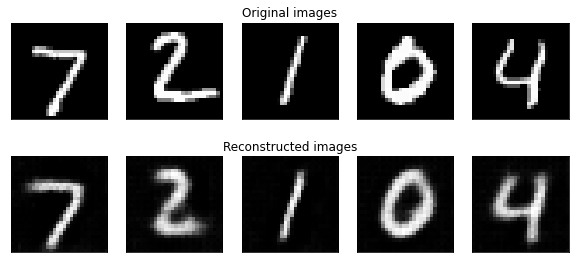

	 partial train loss (single batch): 0.028632
	 partial train loss (single batch): 0.029454
	 partial train loss (single batch): 0.029828
	 partial train loss (single batch): 0.029025
	 partial train loss (single batch): 0.027360
	 partial train loss (single batch): 0.029815
	 partial train loss (single batch): 0.028700
	 partial train loss (single batch): 0.029987
	 partial train loss (single batch): 0.028115
	 partial train loss (single batch): 0.030128
	 partial train loss (single batch): 0.028989
	 partial train loss (single batch): 0.028962
	 partial train loss (single batch): 0.028234
	 partial train loss (single batch): 0.028759
	 partial train loss (single batch): 0.029144
	 partial train loss (single batch): 0.029967
	 partial train loss (single batch): 0.027604
	 partial train loss (single batch): 0.029933
	 partial train loss (single batch): 0.028468
	 partial train loss (single batch): 0.028215
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch

	 partial train loss (single batch): 0.029298
	 partial train loss (single batch): 0.028405
	 partial train loss (single batch): 0.028492
	 partial train loss (single batch): 0.030028
	 partial train loss (single batch): 0.029051
	 partial train loss (single batch): 0.028959
	 partial train loss (single batch): 0.029263
	 partial train loss (single batch): 0.027193
	 partial train loss (single batch): 0.026634

 EPOCH 10/30 	 train loss 0.029 	 val loss 0.029


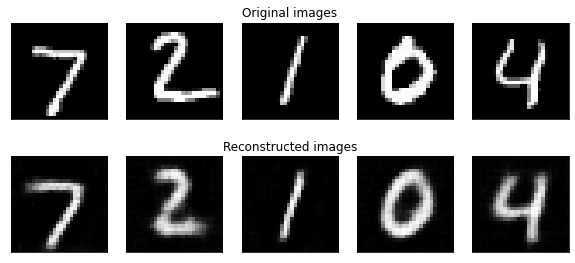

	 partial train loss (single batch): 0.028279
	 partial train loss (single batch): 0.029095
	 partial train loss (single batch): 0.029359
	 partial train loss (single batch): 0.028745
	 partial train loss (single batch): 0.027004
	 partial train loss (single batch): 0.029429
	 partial train loss (single batch): 0.028409
	 partial train loss (single batch): 0.029688
	 partial train loss (single batch): 0.027814
	 partial train loss (single batch): 0.029794
	 partial train loss (single batch): 0.028683
	 partial train loss (single batch): 0.028608
	 partial train loss (single batch): 0.027920
	 partial train loss (single batch): 0.028372
	 partial train loss (single batch): 0.028709
	 partial train loss (single batch): 0.029547
	 partial train loss (single batch): 0.027319
	 partial train loss (single batch): 0.029547
	 partial train loss (single batch): 0.028097
	 partial train loss (single batch): 0.027860
	 partial train loss (single batch): 0.028397
	 partial train loss (single batch

	 partial train loss (single batch): 0.028203
	 partial train loss (single batch): 0.029701
	 partial train loss (single batch): 0.028801
	 partial train loss (single batch): 0.028653
	 partial train loss (single batch): 0.028869
	 partial train loss (single batch): 0.026798
	 partial train loss (single batch): 0.026246

 EPOCH 11/30 	 train loss 0.028 	 val loss 0.029


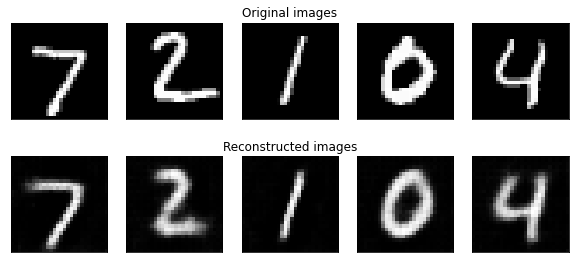

	 partial train loss (single batch): 0.027943
	 partial train loss (single batch): 0.028640
	 partial train loss (single batch): 0.029032
	 partial train loss (single batch): 0.028522
	 partial train loss (single batch): 0.026680
	 partial train loss (single batch): 0.029145
	 partial train loss (single batch): 0.028036
	 partial train loss (single batch): 0.029345
	 partial train loss (single batch): 0.027516
	 partial train loss (single batch): 0.029437
	 partial train loss (single batch): 0.028376
	 partial train loss (single batch): 0.028286
	 partial train loss (single batch): 0.027557
	 partial train loss (single batch): 0.028055
	 partial train loss (single batch): 0.028331
	 partial train loss (single batch): 0.029211
	 partial train loss (single batch): 0.027049
	 partial train loss (single batch): 0.029116
	 partial train loss (single batch): 0.027661
	 partial train loss (single batch): 0.027550
	 partial train loss (single batch): 0.028140
	 partial train loss (single batch

	 partial train loss (single batch): 0.027976
	 partial train loss (single batch): 0.027990
	 partial train loss (single batch): 0.029443
	 partial train loss (single batch): 0.028505
	 partial train loss (single batch): 0.028406
	 partial train loss (single batch): 0.028571
	 partial train loss (single batch): 0.026567
	 partial train loss (single batch): 0.026075

 EPOCH 12/30 	 train loss 0.028 	 val loss 0.029


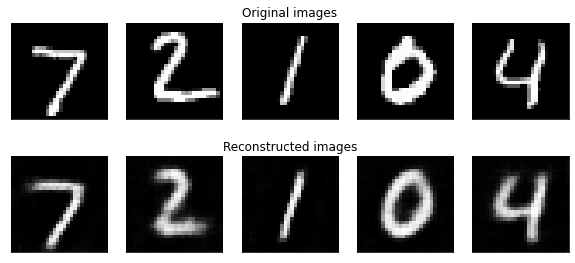

	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.028435
	 partial train loss (single batch): 0.028684
	 partial train loss (single batch): 0.028343
	 partial train loss (single batch): 0.026578
	 partial train loss (single batch): 0.028854
	 partial train loss (single batch): 0.027831
	 partial train loss (single batch): 0.029110
	 partial train loss (single batch): 0.027315
	 partial train loss (single batch): 0.029267
	 partial train loss (single batch): 0.028156
	 partial train loss (single batch): 0.028104
	 partial train loss (single batch): 0.027338
	 partial train loss (single batch): 0.027834
	 partial train loss (single batch): 0.028083
	 partial train loss (single batch): 0.028991
	 partial train loss (single batch): 0.026889
	 partial train loss (single batch): 0.028858
	 partial train loss (single batch): 0.027520
	 partial train loss (single batch): 0.027326
	 partial train loss (single batch): 0.027937
	 partial train loss (single batch

	 partial train loss (single batch): 0.028459
	 partial train loss (single batch): 0.027817
	 partial train loss (single batch): 0.027846
	 partial train loss (single batch): 0.029269
	 partial train loss (single batch): 0.028293
	 partial train loss (single batch): 0.028288
	 partial train loss (single batch): 0.028275
	 partial train loss (single batch): 0.026341
	 partial train loss (single batch): 0.025829

 EPOCH 13/30 	 train loss 0.028 	 val loss 0.028


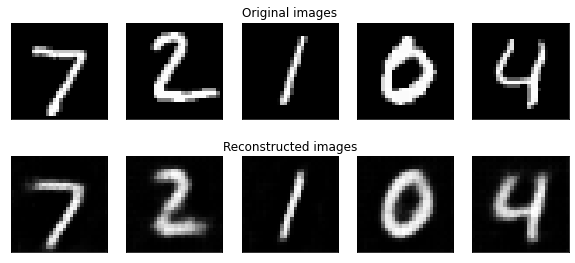

	 partial train loss (single batch): 0.027417
	 partial train loss (single batch): 0.028246
	 partial train loss (single batch): 0.028538
	 partial train loss (single batch): 0.028167
	 partial train loss (single batch): 0.026328
	 partial train loss (single batch): 0.028673
	 partial train loss (single batch): 0.027676
	 partial train loss (single batch): 0.028875
	 partial train loss (single batch): 0.027103
	 partial train loss (single batch): 0.029030
	 partial train loss (single batch): 0.027885
	 partial train loss (single batch): 0.027866
	 partial train loss (single batch): 0.027106
	 partial train loss (single batch): 0.027631
	 partial train loss (single batch): 0.027825
	 partial train loss (single batch): 0.028693
	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.028635
	 partial train loss (single batch): 0.027361
	 partial train loss (single batch): 0.027158
	 partial train loss (single batch): 0.027814
	 partial train loss (single batch

	 partial train loss (single batch): 0.028187
	 partial train loss (single batch): 0.027631
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.029093
	 partial train loss (single batch): 0.028153
	 partial train loss (single batch): 0.028117
	 partial train loss (single batch): 0.028114
	 partial train loss (single batch): 0.026075
	 partial train loss (single batch): 0.025559

 EPOCH 14/30 	 train loss 0.028 	 val loss 0.028


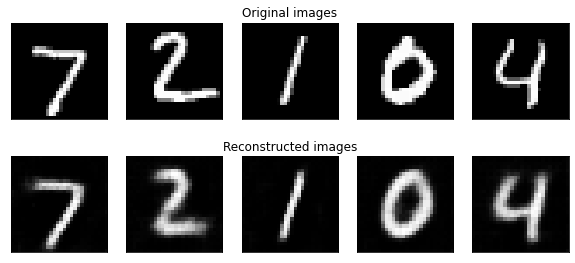

	 partial train loss (single batch): 0.027149
	 partial train loss (single batch): 0.028029
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.028070
	 partial train loss (single batch): 0.026215
	 partial train loss (single batch): 0.028489
	 partial train loss (single batch): 0.027498
	 partial train loss (single batch): 0.028677
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.028837
	 partial train loss (single batch): 0.027637
	 partial train loss (single batch): 0.027694
	 partial train loss (single batch): 0.026885
	 partial train loss (single batch): 0.027442
	 partial train loss (single batch): 0.027630
	 partial train loss (single batch): 0.028630
	 partial train loss (single batch): 0.026538
	 partial train loss (single batch): 0.028516
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.027676
	 partial train loss (single batch

	 partial train loss (single batch): 0.027563
	 partial train loss (single batch): 0.027579
	 partial train loss (single batch): 0.028962
	 partial train loss (single batch): 0.027993
	 partial train loss (single batch): 0.028021
	 partial train loss (single batch): 0.027978
	 partial train loss (single batch): 0.025930
	 partial train loss (single batch): 0.025472

 EPOCH 15/30 	 train loss 0.027 	 val loss 0.028


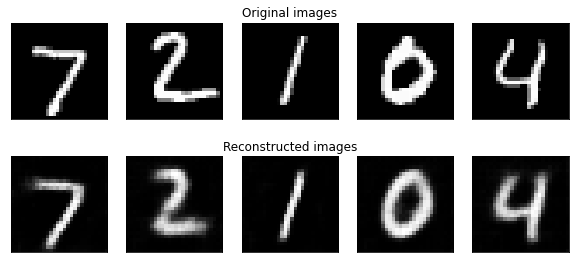

	 partial train loss (single batch): 0.026946
	 partial train loss (single batch): 0.027929
	 partial train loss (single batch): 0.028146
	 partial train loss (single batch): 0.027941
	 partial train loss (single batch): 0.026166
	 partial train loss (single batch): 0.028387
	 partial train loss (single batch): 0.027307
	 partial train loss (single batch): 0.028568
	 partial train loss (single batch): 0.026754
	 partial train loss (single batch): 0.028597
	 partial train loss (single batch): 0.027409
	 partial train loss (single batch): 0.027559
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch): 0.027230
	 partial train loss (single batch): 0.027366
	 partial train loss (single batch): 0.028425
	 partial train loss (single batch): 0.026372
	 partial train loss (single batch): 0.028265
	 partial train loss (single batch): 0.027103
	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.027591
	 partial train loss (single batch

	 partial train loss (single batch): 0.027312
	 partial train loss (single batch): 0.027414
	 partial train loss (single batch): 0.028831
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.027845
	 partial train loss (single batch): 0.027842
	 partial train loss (single batch): 0.025778
	 partial train loss (single batch): 0.025310

 EPOCH 16/30 	 train loss 0.027 	 val loss 0.028


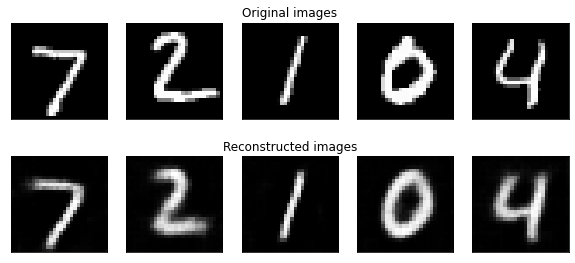

	 partial train loss (single batch): 0.026717
	 partial train loss (single batch): 0.027690
	 partial train loss (single batch): 0.027981
	 partial train loss (single batch): 0.027903
	 partial train loss (single batch): 0.025952
	 partial train loss (single batch): 0.028268
	 partial train loss (single batch): 0.027102
	 partial train loss (single batch): 0.028477
	 partial train loss (single batch): 0.026600
	 partial train loss (single batch): 0.028419
	 partial train loss (single batch): 0.027209
	 partial train loss (single batch): 0.027436
	 partial train loss (single batch): 0.026537
	 partial train loss (single batch): 0.027071
	 partial train loss (single batch): 0.027264
	 partial train loss (single batch): 0.028248
	 partial train loss (single batch): 0.026225
	 partial train loss (single batch): 0.028094
	 partial train loss (single batch): 0.026989
	 partial train loss (single batch): 0.026598
	 partial train loss (single batch): 0.027445
	 partial train loss (single batch

	 partial train loss (single batch): 0.027204
	 partial train loss (single batch): 0.027345
	 partial train loss (single batch): 0.028755
	 partial train loss (single batch): 0.027670
	 partial train loss (single batch): 0.027726
	 partial train loss (single batch): 0.027757
	 partial train loss (single batch): 0.025698
	 partial train loss (single batch): 0.025168

 EPOCH 17/30 	 train loss 0.027 	 val loss 0.028


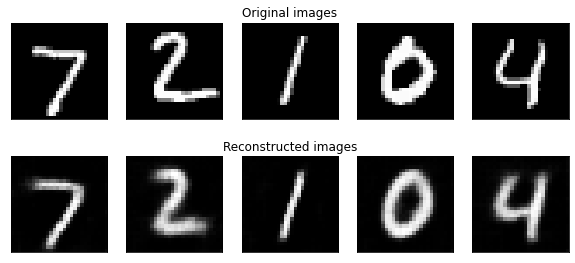

	 partial train loss (single batch): 0.026635
	 partial train loss (single batch): 0.027629
	 partial train loss (single batch): 0.027886
	 partial train loss (single batch): 0.027749
	 partial train loss (single batch): 0.025825
	 partial train loss (single batch): 0.028175
	 partial train loss (single batch): 0.026990
	 partial train loss (single batch): 0.028350
	 partial train loss (single batch): 0.026459
	 partial train loss (single batch): 0.028280
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.027301
	 partial train loss (single batch): 0.026446
	 partial train loss (single batch): 0.026945
	 partial train loss (single batch): 0.027227
	 partial train loss (single batch): 0.028180
	 partial train loss (single batch): 0.026099
	 partial train loss (single batch): 0.027904
	 partial train loss (single batch): 0.026813
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch

	 partial train loss (single batch): 0.027099
	 partial train loss (single batch): 0.027186
	 partial train loss (single batch): 0.028647
	 partial train loss (single batch): 0.027518
	 partial train loss (single batch): 0.027511
	 partial train loss (single batch): 0.027619
	 partial train loss (single batch): 0.025571
	 partial train loss (single batch): 0.025142

 EPOCH 18/30 	 train loss 0.027 	 val loss 0.028


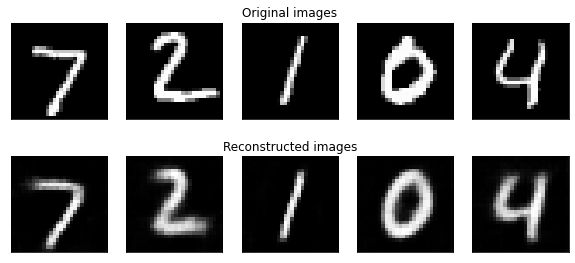

	 partial train loss (single batch): 0.026395
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch): 0.027675
	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.025675
	 partial train loss (single batch): 0.028060
	 partial train loss (single batch): 0.026753
	 partial train loss (single batch): 0.028209
	 partial train loss (single batch): 0.026344
	 partial train loss (single batch): 0.028104
	 partial train loss (single batch): 0.026937
	 partial train loss (single batch): 0.027196
	 partial train loss (single batch): 0.026285
	 partial train loss (single batch): 0.026767
	 partial train loss (single batch): 0.027080
	 partial train loss (single batch): 0.027960
	 partial train loss (single batch): 0.026008
	 partial train loss (single batch): 0.027633
	 partial train loss (single batch): 0.026692
	 partial train loss (single batch): 0.026345
	 partial train loss (single batch): 0.027200
	 partial train loss (single batch

	 partial train loss (single batch): 0.026977
	 partial train loss (single batch): 0.027066
	 partial train loss (single batch): 0.028599
	 partial train loss (single batch): 0.027448
	 partial train loss (single batch): 0.027453
	 partial train loss (single batch): 0.027560
	 partial train loss (single batch): 0.025420
	 partial train loss (single batch): 0.024971

 EPOCH 19/30 	 train loss 0.027 	 val loss 0.028


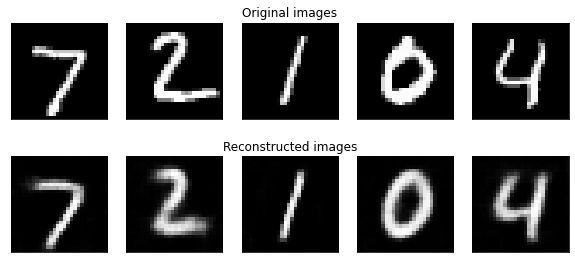

	 partial train loss (single batch): 0.026256
	 partial train loss (single batch): 0.027415
	 partial train loss (single batch): 0.027525
	 partial train loss (single batch): 0.027541
	 partial train loss (single batch): 0.025519
	 partial train loss (single batch): 0.027869
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.028038
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.027948
	 partial train loss (single batch): 0.026778
	 partial train loss (single batch): 0.026997
	 partial train loss (single batch): 0.026129
	 partial train loss (single batch): 0.026611
	 partial train loss (single batch): 0.026970
	 partial train loss (single batch): 0.027854
	 partial train loss (single batch): 0.025904
	 partial train loss (single batch): 0.027543
	 partial train loss (single batch): 0.026584
	 partial train loss (single batch): 0.026127
	 partial train loss (single batch): 0.027040
	 partial train loss (single batch

	 partial train loss (single batch): 0.027300
	 partial train loss (single batch): 0.026816
	 partial train loss (single batch): 0.026901
	 partial train loss (single batch): 0.028504
	 partial train loss (single batch): 0.027283
	 partial train loss (single batch): 0.027351
	 partial train loss (single batch): 0.027442
	 partial train loss (single batch): 0.025314
	 partial train loss (single batch): 0.024893

 EPOCH 20/30 	 train loss 0.027 	 val loss 0.028


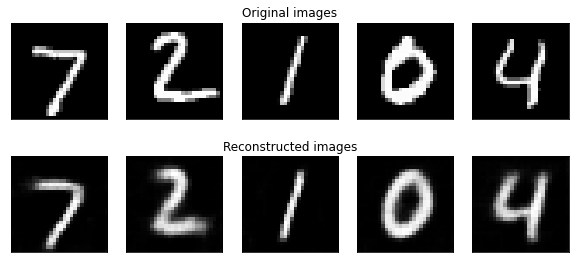

	 partial train loss (single batch): 0.026108
	 partial train loss (single batch): 0.027335
	 partial train loss (single batch): 0.027557
	 partial train loss (single batch): 0.027453
	 partial train loss (single batch): 0.025373
	 partial train loss (single batch): 0.027929
	 partial train loss (single batch): 0.026424
	 partial train loss (single batch): 0.027844
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.027845
	 partial train loss (single batch): 0.026635
	 partial train loss (single batch): 0.026875
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.026844
	 partial train loss (single batch): 0.027750
	 partial train loss (single batch): 0.025862
	 partial train loss (single batch): 0.027396
	 partial train loss (single batch): 0.026474
	 partial train loss (single batch): 0.026027
	 partial train loss (single batch): 0.026910
	 partial train loss (single batch

	 partial train loss (single batch): 0.026670
	 partial train loss (single batch): 0.026826
	 partial train loss (single batch): 0.028366
	 partial train loss (single batch): 0.027217
	 partial train loss (single batch): 0.027298
	 partial train loss (single batch): 0.027371
	 partial train loss (single batch): 0.025225
	 partial train loss (single batch): 0.024782

 EPOCH 21/30 	 train loss 0.027 	 val loss 0.028


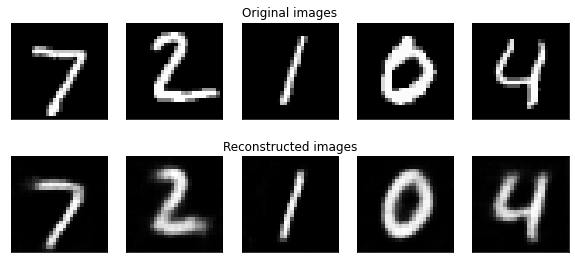

	 partial train loss (single batch): 0.025944
	 partial train loss (single batch): 0.027238
	 partial train loss (single batch): 0.027426
	 partial train loss (single batch): 0.027339
	 partial train loss (single batch): 0.025274
	 partial train loss (single batch): 0.027868
	 partial train loss (single batch): 0.026331
	 partial train loss (single batch): 0.027742
	 partial train loss (single batch): 0.026070
	 partial train loss (single batch): 0.027807
	 partial train loss (single batch): 0.026540
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.025814
	 partial train loss (single batch): 0.026412
	 partial train loss (single batch): 0.026758
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.025811
	 partial train loss (single batch): 0.027361
	 partial train loss (single batch): 0.026381
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.026785
	 partial train loss (single batch

	 partial train loss (single batch): 0.026622
	 partial train loss (single batch): 0.026776
	 partial train loss (single batch): 0.028231
	 partial train loss (single batch): 0.027016
	 partial train loss (single batch): 0.027156
	 partial train loss (single batch): 0.027353
	 partial train loss (single batch): 0.025167
	 partial train loss (single batch): 0.024768

 EPOCH 22/30 	 train loss 0.027 	 val loss 0.028


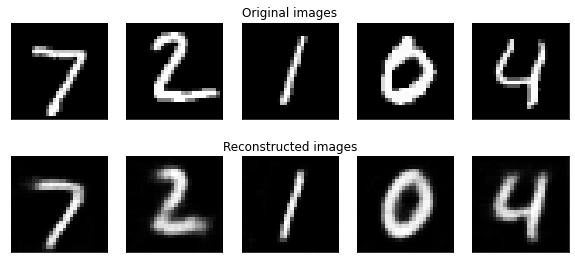

	 partial train loss (single batch): 0.025855
	 partial train loss (single batch): 0.027190
	 partial train loss (single batch): 0.027238
	 partial train loss (single batch): 0.027342
	 partial train loss (single batch): 0.025174
	 partial train loss (single batch): 0.027654
	 partial train loss (single batch): 0.026247
	 partial train loss (single batch): 0.027683
	 partial train loss (single batch): 0.025957
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.026517
	 partial train loss (single batch): 0.026671
	 partial train loss (single batch): 0.025702
	 partial train loss (single batch): 0.026313
	 partial train loss (single batch): 0.026572
	 partial train loss (single batch): 0.027493
	 partial train loss (single batch): 0.025790
	 partial train loss (single batch): 0.027222
	 partial train loss (single batch): 0.026385
	 partial train loss (single batch): 0.025850
	 partial train loss (single batch): 0.026618
	 partial train loss (single batch

	 partial train loss (single batch): 0.026521
	 partial train loss (single batch): 0.026647
	 partial train loss (single batch): 0.028148
	 partial train loss (single batch): 0.026912
	 partial train loss (single batch): 0.027040
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.025084
	 partial train loss (single batch): 0.024718

 EPOCH 23/30 	 train loss 0.026 	 val loss 0.027


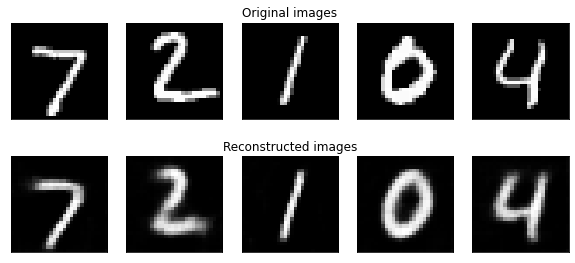

	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.027041
	 partial train loss (single batch): 0.027091
	 partial train loss (single batch): 0.027177
	 partial train loss (single batch): 0.025013
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.026058
	 partial train loss (single batch): 0.027610
	 partial train loss (single batch): 0.025835
	 partial train loss (single batch): 0.027448
	 partial train loss (single batch): 0.026410
	 partial train loss (single batch): 0.026503
	 partial train loss (single batch): 0.025561
	 partial train loss (single batch): 0.026273
	 partial train loss (single batch): 0.026459
	 partial train loss (single batch): 0.027384
	 partial train loss (single batch): 0.025668
	 partial train loss (single batch): 0.027094
	 partial train loss (single batch): 0.026235
	 partial train loss (single batch): 0.025751
	 partial train loss (single batch): 0.026544
	 partial train loss (single batch

	 partial train loss (single batch): 0.026425
	 partial train loss (single batch): 0.026511
	 partial train loss (single batch): 0.028129
	 partial train loss (single batch): 0.026773
	 partial train loss (single batch): 0.026908
	 partial train loss (single batch): 0.027194
	 partial train loss (single batch): 0.025024
	 partial train loss (single batch): 0.024615

 EPOCH 24/30 	 train loss 0.026 	 val loss 0.027


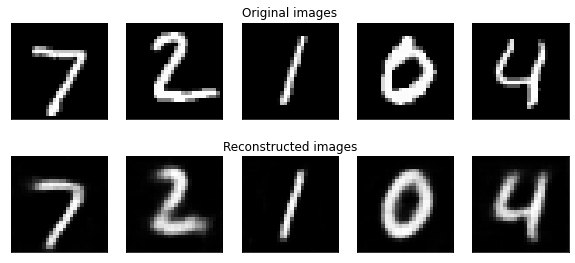

	 partial train loss (single batch): 0.025621
	 partial train loss (single batch): 0.026928
	 partial train loss (single batch): 0.026959
	 partial train loss (single batch): 0.027061
	 partial train loss (single batch): 0.025014
	 partial train loss (single batch): 0.027538
	 partial train loss (single batch): 0.025967
	 partial train loss (single batch): 0.027534
	 partial train loss (single batch): 0.025755
	 partial train loss (single batch): 0.027279
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.026390
	 partial train loss (single batch): 0.025460
	 partial train loss (single batch): 0.026254
	 partial train loss (single batch): 0.026399
	 partial train loss (single batch): 0.027200
	 partial train loss (single batch): 0.025628
	 partial train loss (single batch): 0.026918
	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.025709
	 partial train loss (single batch): 0.026346
	 partial train loss (single batch

	 partial train loss (single batch): 0.026377
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.028051
	 partial train loss (single batch): 0.026684
	 partial train loss (single batch): 0.026752
	 partial train loss (single batch): 0.027111
	 partial train loss (single batch): 0.025065
	 partial train loss (single batch): 0.024551

 EPOCH 25/30 	 train loss 0.026 	 val loss 0.027


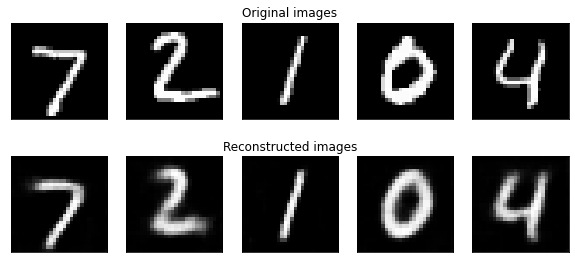

	 partial train loss (single batch): 0.025604
	 partial train loss (single batch): 0.026874
	 partial train loss (single batch): 0.026906
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch): 0.024948
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.025874
	 partial train loss (single batch): 0.027476
	 partial train loss (single batch): 0.025708
	 partial train loss (single batch): 0.027154
	 partial train loss (single batch): 0.026328
	 partial train loss (single batch): 0.026289
	 partial train loss (single batch): 0.025340
	 partial train loss (single batch): 0.026248
	 partial train loss (single batch): 0.026259
	 partial train loss (single batch): 0.027184
	 partial train loss (single batch): 0.025576
	 partial train loss (single batch): 0.026882
	 partial train loss (single batch): 0.026081
	 partial train loss (single batch): 0.025602
	 partial train loss (single batch): 0.026248
	 partial train loss (single batch

	 partial train loss (single batch): 0.026798
	 partial train loss (single batch): 0.026299
	 partial train loss (single batch): 0.026320
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.026612
	 partial train loss (single batch): 0.026690
	 partial train loss (single batch): 0.027032
	 partial train loss (single batch): 0.025018
	 partial train loss (single batch): 0.024423

 EPOCH 26/30 	 train loss 0.026 	 val loss 0.027


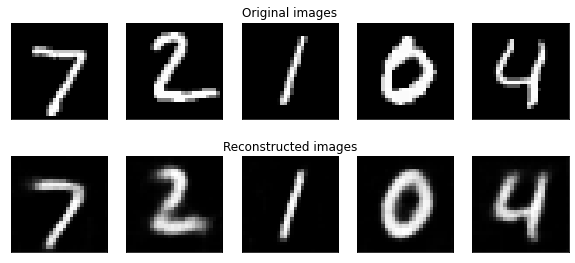

	 partial train loss (single batch): 0.025458
	 partial train loss (single batch): 0.026735
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.026799
	 partial train loss (single batch): 0.024917
	 partial train loss (single batch): 0.027366
	 partial train loss (single batch): 0.025740
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.025634
	 partial train loss (single batch): 0.027040
	 partial train loss (single batch): 0.026246
	 partial train loss (single batch): 0.026180
	 partial train loss (single batch): 0.025201
	 partial train loss (single batch): 0.026105
	 partial train loss (single batch): 0.026181
	 partial train loss (single batch): 0.027037
	 partial train loss (single batch): 0.025500
	 partial train loss (single batch): 0.026681
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.025473
	 partial train loss (single batch): 0.026199
	 partial train loss (single batch

	 partial train loss (single batch): 0.026186
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.027898
	 partial train loss (single batch): 0.026599
	 partial train loss (single batch): 0.026601
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.025011
	 partial train loss (single batch): 0.024423

 EPOCH 27/30 	 train loss 0.026 	 val loss 0.027


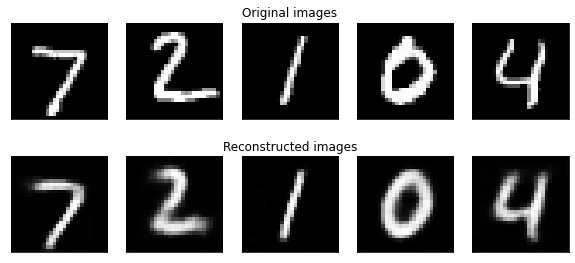

	 partial train loss (single batch): 0.025344
	 partial train loss (single batch): 0.026602
	 partial train loss (single batch): 0.026809
	 partial train loss (single batch): 0.026657
	 partial train loss (single batch): 0.024804
	 partial train loss (single batch): 0.027259
	 partial train loss (single batch): 0.025656
	 partial train loss (single batch): 0.027220
	 partial train loss (single batch): 0.025565
	 partial train loss (single batch): 0.026879
	 partial train loss (single batch): 0.026150
	 partial train loss (single batch): 0.026111
	 partial train loss (single batch): 0.025130
	 partial train loss (single batch): 0.026007
	 partial train loss (single batch): 0.026086
	 partial train loss (single batch): 0.026911
	 partial train loss (single batch): 0.025352
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.025834
	 partial train loss (single batch): 0.025420
	 partial train loss (single batch): 0.026047
	 partial train loss (single batch

	 partial train loss (single batch): 0.026655
	 partial train loss (single batch): 0.026008
	 partial train loss (single batch): 0.026204
	 partial train loss (single batch): 0.027796
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.026473
	 partial train loss (single batch): 0.026932
	 partial train loss (single batch): 0.024974
	 partial train loss (single batch): 0.024368

 EPOCH 28/30 	 train loss 0.026 	 val loss 0.027


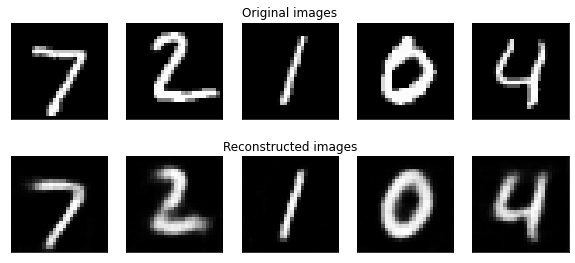

	 partial train loss (single batch): 0.025305
	 partial train loss (single batch): 0.026566
	 partial train loss (single batch): 0.026791
	 partial train loss (single batch): 0.026599
	 partial train loss (single batch): 0.024693
	 partial train loss (single batch): 0.027158
	 partial train loss (single batch): 0.025661
	 partial train loss (single batch): 0.027182
	 partial train loss (single batch): 0.025538
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.026091
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.025038
	 partial train loss (single batch): 0.025960
	 partial train loss (single batch): 0.026024
	 partial train loss (single batch): 0.026788
	 partial train loss (single batch): 0.025317
	 partial train loss (single batch): 0.026450
	 partial train loss (single batch): 0.025880
	 partial train loss (single batch): 0.025405
	 partial train loss (single batch): 0.026015
	 partial train loss (single batch

	 partial train loss (single batch): 0.026628
	 partial train loss (single batch): 0.025985
	 partial train loss (single batch): 0.026101
	 partial train loss (single batch): 0.027756
	 partial train loss (single batch): 0.026401
	 partial train loss (single batch): 0.026496
	 partial train loss (single batch): 0.026863
	 partial train loss (single batch): 0.024895
	 partial train loss (single batch): 0.024343

 EPOCH 29/30 	 train loss 0.026 	 val loss 0.027


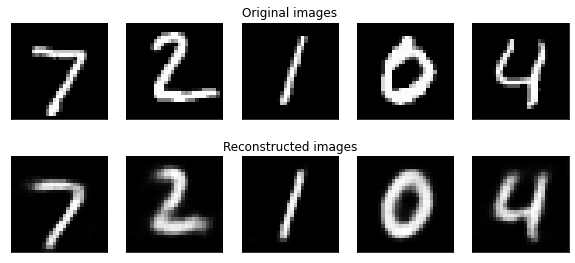

	 partial train loss (single batch): 0.025254
	 partial train loss (single batch): 0.026467
	 partial train loss (single batch): 0.026656
	 partial train loss (single batch): 0.026594
	 partial train loss (single batch): 0.024673
	 partial train loss (single batch): 0.027101
	 partial train loss (single batch): 0.025559
	 partial train loss (single batch): 0.027111
	 partial train loss (single batch): 0.025409
	 partial train loss (single batch): 0.026729
	 partial train loss (single batch): 0.025962
	 partial train loss (single batch): 0.026052
	 partial train loss (single batch): 0.024935
	 partial train loss (single batch): 0.025765
	 partial train loss (single batch): 0.025904
	 partial train loss (single batch): 0.026706
	 partial train loss (single batch): 0.025213
	 partial train loss (single batch): 0.026377
	 partial train loss (single batch): 0.025817
	 partial train loss (single batch): 0.025309
	 partial train loss (single batch): 0.025922
	 partial train loss (single batch

	 partial train loss (single batch): 0.025892
	 partial train loss (single batch): 0.026100
	 partial train loss (single batch): 0.027760
	 partial train loss (single batch): 0.026353
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.026819
	 partial train loss (single batch): 0.024883
	 partial train loss (single batch): 0.024235

 EPOCH 30/30 	 train loss 0.026 	 val loss 0.027


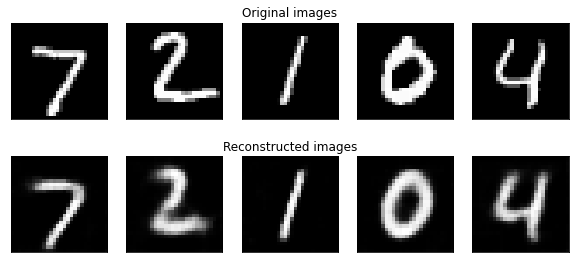

In [14]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):

   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=5)

In [15]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02664177678525448

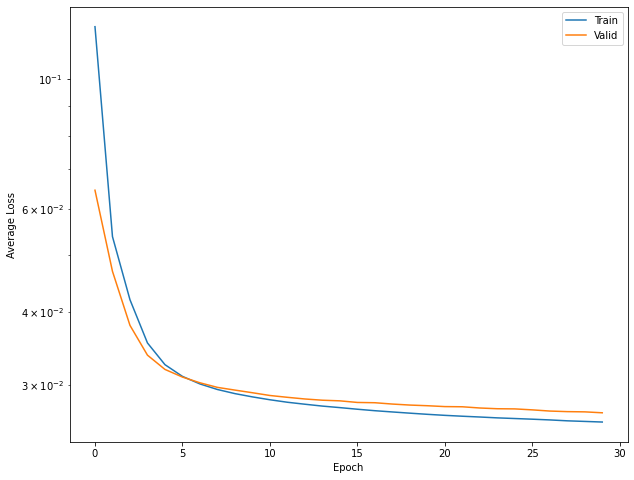

In [16]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [17]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')
    plt.show()

In [18]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x128)

<Figure size 1440x612 with 0 Axes>

In [19]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2843.17it/s]


In [20]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -2.300374         1.688546         0.051322         0.205896   
1            0.156925         0.970089         1.318778         0.555583   
2            0.010784         0.902848        -0.444754         1.483704   
3           -0.002750        -0.863663         0.535699        -0.422413   
4           -0.512528        -0.131012        -0.448902        -0.833469   
...               ...              ...              ...              ...   
9995        -0.556415         0.600231         0.955741         0.559926   
9996         0.474045         0.475309         1.424105         0.203470   
9997        -0.760088        -0.027152        -0.695781        -0.040765   
9998         0.810733        -1.621808        -0.831636         0.401862   
9999        -0.253634        -0.509116         0.370789        -0.163770   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [21]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

NameError: name 'px' is not defined

In [ ]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(encoded_samples.drop(['label'],axis=1))
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

In [ ]:
fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

In [ ]:
plt.figure(figsize=(17, 9))
plt.scatter(components[:,0], components[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))


In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [ ]:
plt.figure(figsize=(17, 9))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()